# Imports

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 15]

# Data

In [2]:
IMG_PATH = '../data/dss/scrolls/P123-Fg002-R-C01-R01-binarized.jpg'

def pimg(im, **kwargs):
    if im is None:
        print('no image!')
        return
    try:
        cim = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    except:
        cim = im
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cim, **kwargs)
    plt.show()

def write_cc(img, cc):
    try:
        cimg = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    except:
        cimg = img
    cv.rectangle(cimg, (cc.x,cc.y), (cc.x+cc.w, cc.y+cc.h), (0,255,0), 2)
    return cimg

In [4]:
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Tuple, Union

import cv2 as cv
import numpy as np
from peakdetect import peakdetect


@dataclass
class ConnectedComponent:
    """A dataclass that contains all information for one connected component in an image.
    """
    x: int
    y: int
    w: int
    h: int
    a: int
    cx: float
    cy: float


@dataclass
class LineSegment:
    """A dataclass that contains information necessary to put a line segment and its containing connected components
    back into the originating image.
    """
    top: ConnectedComponent
    bot: ConnectedComponent
    left: ConnectedComponent
    right: ConnectedComponent
    x_offset: int
    y_offset: int
    width: int
    height: int
    components: List[ConnectedComponent]


def get_line_image_from_ccs(image: np.ndarray, ccs_line: List[ConnectedComponent]) -> Union[Tuple[np.ndarray, LineSegment], Tuple[None, None]]:
    """Given an image and a list of connected components, get a slice of the image that only contains the given
    connected components.

    :rtype: np.ndarray
    :param image: The source image.
    :param ccs_line: The connected components to slice with
    :return: A slice of the source image containing only the given connected components
    """
    # print(ccs_line)
    if len(ccs_line) == 0:
        return None, None
    topmost_cc = ccs_line[np.argmin([cc.y for cc in ccs_line])]
    bottommost_cc = ccs_line[np.argmax([cc.y + cc.h for cc in ccs_line])]
    leftmost_cc = ccs_line[np.argmin([cc.x for cc in ccs_line])]
    rightmost_cc = ccs_line[np.argmax([cc.x + cc.w for cc in ccs_line])]
    height = bottommost_cc.y + bottommost_cc.h - topmost_cc.y
    width = rightmost_cc.x + rightmost_cc.w - leftmost_cc.x
    line_image = np.zeros((height, width), dtype=np.uint8)
    x_offset = leftmost_cc.x
    y_offset = topmost_cc.y
    data = LineSegment(topmost_cc, bottommost_cc, leftmost_cc, rightmost_cc, x_offset, y_offset, width, height, ccs_line
                       )
    for cc in ccs_line:
        y_l = cc.y - y_offset
        x_l = cc.x - x_offset
        line_image[y_l:y_l + cc.h, x_l:x_l + cc.w] = \
            image[cc.y:cc.y + cc.h, cc.x:cc.x + cc.w]
    return line_image, data


def get_ccs_per_line(ccs: List[ConnectedComponent], minima: List[List[int]], image_height: int) \
        -> List[List[ConnectedComponent]]:
    """Given a list of connected components and a list op minima (formatted as `peakdetect.peakdetect`), order the
    connected components by the line it is contained within.

    :param ccs: The connected components
    :param minima: The list of minima (minima[x] = [location, value])
    :param image_height: The height of the source image used to determine the last line height
    :return: A list containing all connected components per line
    """
    ccs_per_line = []
    for i in range(len(minima) + 1):
        curr_line = minima[i][0] if i < len(minima) else image_height
        last_line = minima[i - 1][0] if i > 0 else 0
        ccs_curr_line = [cc for cc in ccs if last_line <= cc.cy < curr_line]
        ccs_per_line.append(ccs_curr_line)
    return ccs_per_line


def preprocessed(image: np.ndarray) -> np.ndarray:
    """Return the source image, preprocessed (converted to greyscale and thresholded).

    :param image: The source image
    :return: The preprocessed source image.
    """
    result = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, result = cv.threshold(result, 127, 255, cv.THRESH_BINARY_INV)
    # result = skeletonize_pass(image)
    return result


def extract_cc(image: np.ndarray, cc: ConnectedComponent) -> np.ndarray:
    """Get a slice of an image that only contains the part that is contained within a connected component.

    :param image: The source image
    :param cc: The connected component
    :return: The image slice
    """
    return image[cc.y:cc.y + cc.h, cc.x:cc.x + cc.w]


def get_ccs_from_image(image: np.ndarray) -> np.ndarray:
    """Get all connected components of an image.

    :param image: The source image
    :return: The list of connected components
    """
    _, _, stats, centroids = cv.connectedComponentsWithStats(image)
    return [
        ConnectedComponent(*stat.tolist(), *centroids[i].tolist())
        for i, stat in enumerate(stats)
    ]


def line_segment_image(input_image: np.ndarray, peak_lookahead: int = 40, cc_min_a: int = 500, cc_max_a: int = 1e5) \
        -> Tuple[List[np.ndarray], List[Dict[str, Any]]]:
    """Perform line segmentation on an image, using the reduction method.

    :param input_image: The source image.
    :param peak_lookahead: Lookahead used by the peak detection algorithm
    :param cc_min_a: The minimum area of the connected components to use
    :param cc_max_a: The maximum area of the connected components to use
    :return: The line images and the metadata of the line segments
    """
    image = preprocessed(input_image)
    ccs = get_ccs_from_image(image)
    ccs = [cc for cc in ccs if cc_min_a <= cc.a <= cc_max_a]
    reduced = cv.reduce(image // 255, 1, cv.REDUCE_SUM, dtype=cv.CV_32S)
    _, minima = peakdetect(reduced, lookahead=peak_lookahead)
    ccs_per_line = get_ccs_per_line(ccs, minima, image.shape[1])
    lines = [
        get_line_image_from_ccs(image, ccs_line)
        for ccs_line in ccs_per_line if ccs_line
    ]
    line_images = [line[0] for line in lines]
    metadata = [asdict(line[1]) for line in lines]
    return line_images, metadata


class ProjectionSegmenter:
    pass


In [5]:
def skeletonize(image):
    skeleton = np.zeros(image.shape, np.uint8)
    se = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
    while True:
        opened = cv.morphologyEx(image, cv.MORPH_OPEN, se)
        temp = cv.subtract(image, opened)
        eroded = cv.erode(image, se)
        skeleton = cv.bitwise_or(skeleton, temp)
        image = eroded.copy()
        if cv.countNonZero(image) == 0:
            break

    return skeleton

def skeletonize_pass(image):
    skeleton = np.zeros(image.shape, np.uint8)
    se = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
    opened = cv.morphologyEx(image, cv.MORPH_OPEN, se)
    temp = cv.subtract(image, opened)
    skeleton = cv.bitwise_or(skeleton, temp)
    return skeleton

def test():
    img, d = line_segment_image(cv.imread(IMG_PATH), cc_min_a=1)
    for im in img:
        pimg(im, cmap='binary')

# test()

In [ ]:
img = cv.imread(IMG_PATH)
pimg(img)

In [6]:
from imutils import rotate_bound, rotate

def crop(image):
    coords = cv.findNonZero(image)
    x,y,w,h = cv.boundingRect(coords)
    return image[y:y+h, x:x+w], (x,y,w,h)

def consecutive(array):
    return np.split(array, np.where(np.diff(array) != 1)[0]+1)

def reduce_optimally(image, axis=0):
    best = 0
    reductions = []
    for angle in range(-20, 20, 2):
        # print(best, angle)
        # print(image.shape)
        rotated = rotate(image, angle)
        # print('shape:',rotated.shape)
        # cropped, dims = crop(rotated)
        # if len(cropped) == 0:
        #     print("image contains only black pixels!")
        #     return None
        reduced = cv.reduce(rotated // 255, axis, cv.REDUCE_SUM, dtype=cv.CV_32S).flatten()
        _, minima = peakdetect(reduced, lookahead=60, delta=0)
        # fig,(ax1, ax2) = plt.subplots(1, 2)
        # ax1.imshow(cropped, cmap='binary')
        # ax2.plot(reduced)
        # plt.show()
        # curr = len(consecutive(np.argwhere(reduced[30:-30]<=10).flatten()))
        candidates = [minimum for minimum in minima if minimum[1] <= 30]
        # print(f'a{angle}: {candidates}')
        curr = len(candidates)
        if curr > best:
            best = curr
            reductions = [(angle, candidates, (0,0,0,0))]
        elif 0 < best == curr:
            reductions.append((angle, candidates, (0,0,0,0)))

    if not reductions:
        print("could not find any peaks!")
        return None
    print(reductions[len(reductions) // 2])
    return reductions[len(reductions) // 2]

https://math.stackexchange.com/questions/1064832/rotate-a-line-by-a-given-angle-about-a-point
https://www.desmos.com/calculator/jn7yhrvutv

In [20]:
def rotated_line_eq(shape, angle, axis, val):
    y0 = shape[0] // 2
    x0 = shape[1] // 2
    angle = angle * (np.pi / 180)
    val *= -1
    if axis == 0:
        return \
            lambda x: x, \
            lambda y: int(round(-(((np.cos(angle) * (x - y0)) + y0 + val) / np.sin(angle)) + x0))
    if axis == 1:
        return \
            lambda x: int(round(-(((np.sin(angle) * (x - x0)) + y0 + val) / np.cos(angle)) + y0)), \
            lambda y: y

def equations_from_reductions(image, angle, candidates, dimensions, axis):
    # where_zeros = np.argwhere(reductions<=10).flatten()
    # line_breaks = [int(np.mean(x)) for x in consecutive(where_zeros)]
    # _, minima = peakdetect(candidates, lookahead=40, delta=10)
    line_breaks, magnitudes = zip(*candidates)
    for line_break in line_breaks:
        # line_break += dimensions[axis] // 2
        yield rotated_line_eq(image.shape, -angle, axis, line_break)

def rot_from_red(image, angle, candidates, dimensions, axis):
    # where_zeros = np.argwhere(reduced<=10).flatten()
    # consecutive_zeros = np.split(where_zeros, np.where(np.diff(where_zeros) != 1)[0]+1)
    # line_breaks = [int(np.mean(x)) for x in consecutive_zeros]
    line_breaks, magnitudes = zip(*candidates)
    img_rot = rotate(image, angle)
    try:
        img_rot = cv.cvtColor(img_rot, cv.COLOR_GRAY2RGB)
    except:
        pass
        # print('couldnt change color')
    for line_break  in line_breaks:
        line_break += dimensions[axis] // 2
        pt1 = [0,0]
        pt2 = [img_rot.shape[axis], img_rot.shape[axis]]
        pt1[axis] = line_break
        pt2[axis] = line_break
        cv.line(img_rot, tuple(pt1), tuple(pt2), (0,255,0))
    return img_rot

def test_rot(axis=1):
    im = cv.imread(IMG_PATH)
    # pimg(im)
    im = preprocessed(im)
    # pimg(im)
    im, d = crop(im)
    # pimb(im)
    im = im[0:352, 615:1230]
    im, d = crop(im)
    print(im.shape)
    reductions = reduce_optimally(im, axis=axis)
    rim = rot_from_red(im, *reductions, axis=axis)
    pimg(rim)
    eqs = equations_from_reductions(im, *reductions, axis=axis)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    for x,y in eqs:
        print(x(0), y(0))
        cv.line(im, (y(0), x(0)), (y(im.shape[1]), x(im.shape[1])), (0, 255, 0), 1)
    pimg(im)

test_rot()

(157, 615)
could not find any peaks!


TypeError: Value after * must be an iterable, not NoneType

In [15]:
from dataclasses import dataclass

@dataclass
class Rect:
    x: int
    y: int
    w: int
    h: int

In [12]:
## Image splitting methods
def to_grid(image, n_rows, n_cols):
    h = image.shape[0]
    w = image.shape[1]
    m = h // n_rows
    n = w // n_cols
    tiles = []
    for r, y in enumerate(range(0, h, m)):
        for c, x in enumerate(range(0, w, n)):
            tile = image[y:y+m, x:x+n]
            rect = Rect(x=x, y=y, w=n, h=m)
            tiles.append((rect, tile))

    return tiles

def to_chunks(image, n_chunks):
    w = image.shape[1]
    chunk_w, remainder = divmod(w, n_chunks)
    chunks = []
    for i in range(n_chunks - remainder):
        x = i * chunk_w
        chunks.append(image[..., x:x+chunk_w])
    for i in range(n_chunks - remainder, n_chunks):
        x = i * chunk_w
        chunks.append(image[..., x:x+chunk_w+1])
    return chunks

In [ ]:
def test(axis=1):
    im = cv.imread(IMG_PATH)
    im = preprocessed(im)
    ccs = get_ccs_from_image(im)
    extreme_ccs = [cc for cc in ccs if cc.a < 500]
    for cc in extreme_ccs:
        im[cc.y:cc.y+cc.h, cc.x:cc.x+cc.w] = np.zeros((cc.h, cc.w))
    im, d = crop(im)
    pimg(im)
    tiles = to_grid(im, 2, 2)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    i=0
    for (pos, tile) in tiles:
        if cv.countNonZero(tile) < 5:
            continue
        reductions = reduce_optimally(tile, axis=axis)
        tile, tile_dim = crop(tile)
        tile = cv.cvtColor(tile, cv.COLOR_GRAY2RGB)
        if reductions:
            i+=1
            path = f'/home/jsk/Study/2-4-hwr/Handwriting_Recognition/jesper_tests/out/{i}.jpg'
            rotim = rot_from_red(tile, *reductions, axis=axis)
            # print(f"writing to {path}")
            cv.imwrite(path, rotim)
            eqs = equations_from_reductions(tile, *reductions, axis=axis)
            for x,y in eqs:
                x_offset = pos.x + tile_dim[0]
                y_offset = pos.y + tile_dim[1]
                cv.line(tile, (y(0), x(0)), (y(tile.shape[1]), x(tile.shape[1])), (0, 255, 0), 1)
                cv.line(im, (y(0)+x_offset, x(0)+y_offset), (y(tile.shape[1])+x_offset, x(tile.shape[1])+y_offset), (0, 255, 0), 1)
            # print(r)
            fig, (a1, a2) = plt.subplots(1, 2)
            a1.imshow(rotim, cmap='binary')
            a2.imshow(tile, cmap='binary')
            plt.show()
            # pimg(tile)
    pimg(im)

test()

## Things that were tried
- Add new line when someone else is already bound to a previous line ending: Didn't help (only more shenanigans with lamed et consortes)

In [98]:
def projection_profile(chunk, window_length=20):
    reduced = cv.reduce(chunk // 255, 1, cv.REDUCE_SUM, dtype=cv.CV_32S).flatten()
    kernel = np.ones(window_length) / window_length
    return np.convolve(reduced, kernel, mode='same')


def consecutive(array):
    return np.split(array, np.where(np.diff(array) != 1)[0]+1)


def valleys_from_profile(profile, lookahead, plot=False, *args, **kwargs):
    peaks, _ = peakdetect(np.hstack((profile, [0]*lookahead)), lookahead=lookahead)
    if len(peaks) == 0:
        return []
    peak_locs, _ = zip(*peaks)
    # if 'second_pass' in args:
    if plot:
        plt.plot(profile)
        for y in peak_locs:
            plt.axvline(y)
    valley_locs = []
    for i, y in enumerate(peak_locs):
        if i == 0:
            continue
        y_lag = peak_locs[i-1]
        if y_lag-y == 0:
            continue
        slice = profile[y_lag:y]
        consec = consecutive(np.argwhere(slice==min(slice)).flatten())
        longest_consec = consec[np.argmax(np.array(list(map(len, consec))))]
        valley_locs.append(int(np.mean(longest_consec)) + y_lag)
    if plot:
        for valley in valley_locs:
            plt.axvline(valley)
        plt.show()
    return valley_locs


def valleys_from_profiles(profile, lookahead):
    _, valleys = peakdetect(np.hstack((profile, [0]*lookahead)), lookahead=lookahead)
    if len(valleys) == 0: return []
    locs, _ = zip(*valleys)
    return list(locs)


def annotate_image_with_lines(im, chunks, lines):
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    for line in lines:
        x = im.shape[1]
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            cv.line(im, (x,y), (x-w, y), (0, 255, 0), 2)
            if i < len(line)-1:
                prev_y = line[i-1]
                cv.line(im, (x, y), (x,prev_y), (0, 255, 0), 2)
            x -= w
    return im


def annotate_image_with_line_w(im, lines):
    try:
        im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    except:
        pass
    for line in lines:
        x = im.shape[1]
        for i, (y, w) in enumerate(line):
            cv.line(im, (x, y), (x-w, y), (0, 255, 0), 2)
            if i != 0:
                prev_y = line[i-1][0]
                cv.line(im, (x,y), (x, prev_y), (0, 255, 0), 2)
            x -= w
    return im

def verbose(level):
    def print_v(*args, **kwargs):
        i = 5
        if 'level' in kwargs:
            i = kwargs['level']
            del kwargs['level']
        if i <= level:
            print(*args, **kwargs)
    return print_v

def none(*args, **kwargs):
    pass


from pprint import pprint
def traverse(im, n_splits=20, line_start_splits=10, start_lookahead=50, chunk_lookahead=40, expected_line_height=200, second_pass=False, log=none):
    im, dims = crop(im)
    # if second_pass:
    #     print("Second pass!")
    #     pimg(im)
    if cv.countNonZero(im) == 0:
        print('Empty image!')
        return [], dims
    chunks = to_chunks(im, n_splits)

    # Line starts
    start = np.column_stack(tuple(chunks[-line_start_splits:]))
    prof = projection_profile(start)
    line_starts = valleys_from_profile(prof, lookahead=start_lookahead)
    if len(line_starts) == 0:
        return [], dims

    lines = [[y] for y in line_starts]
    valleys_per_chunk = [valleys_from_profile(projection_profile(chunk), reverse=False, lookahead=chunk_lookahead) \
                               for chunk in chunks]

    # extra lines found in the middle
    additional_lines = []

    # Line traversal
    for i in range(2, n_splits+1):
        log(f'\nChunk {i}')
        curr_valleys = valleys_per_chunk[-i]
        log(f'Valleys at {curr_valleys}')
        line_ending_to_closest_valley = {}
        line_endings = [line[-1] for line in lines]
        log(f'Line endings at {line_endings}')
        for valley in curr_valleys:
            log(f'Valley {valley}')
            distances = np.array([abs(valley - line_ending) for line_ending in line_endings])
            log(f'\tDistances: {distances}')
            closest_line_ending_idx = np.argmin(distances)
            closest_line_ending = line_endings[closest_line_ending_idx]
            distance_to_closest_line_ending = distances[closest_line_ending_idx]
            log(f'\tClosest at {closest_line_ending_idx}: {closest_line_ending} w/ distance {distance_to_closest_line_ending}')
            if distance_to_closest_line_ending > expected_line_height * .8:
                log('\tToo far!')
                continue
            if closest_line_ending in line_ending_to_closest_valley:
                other, other_distance = line_ending_to_closest_valley[closest_line_ending]
                log(f'\tAlready used by {other} w/ dist {other_distance}')
                if distance_to_closest_line_ending < other_distance:
                    log(f'\tIm closer! Throwing them out...')
                    line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
                    # new_line = [closest_line_ending] * (i-2) + [other]
                    # print(f"new line at {valley}")
                    # lines.append(new_line)
                else:
                    # TODO: inline annotations oppikken
                    log(f'\tThey are closer, I guess I\'m out...')
                    # print(f'new line at {valley}')
                    # new_line = [closest_line_ending] * (i-2) + [valley]
                    # lines.append(new_line)

            else:
                log(f'\tFirst! Assigning...')
                line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
        log(line_ending_to_closest_valley)

        for line in lines:
            line_ending = line[-1]
            log(f'looking for line from line ending {line_ending}')
            next_y = line_ending_to_closest_valley[line_ending][0] if line_ending in line_ending_to_closest_valley else line_ending
            log(f'next: {next_y}')
            line.append(next_y)
    # End for chunk in chunks

    # Add line segment (chunk) size to every line segment
    lines_full = []
    for line in lines:
        line_full = []
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            line_full += [(y, w)]
        lines_full.append(line_full)

    # Get heights of every line
    line_heights = []
    for i, line_start in enumerate(line_starts):
        if i==0:
            line_heights.append(line_start)
        else:
            line_heights.append(line_start - line_starts[i-1])
    line_heights.append(im.shape[0] - line_starts[-1])
    line_heights = np.array(line_heights)

    # Add line starting at the top of im
    line_starts.insert(0, 0)

    imw = im.shape[1]
    imh = im.shape[0]
    mean = line_heights.mean()
    std = line_heights.std()
    for i, line_height in enumerate(line_heights):
        # print(i, line_height)
        if line_height > expected_line_height:
            mess = 'nested' if second_pass else ''
            log(f"\n{mess} second pass for line {i}")
            y_from = line_starts[i]
            y_to = line_starts[i+1] if i < len(line_starts)-1 else im.shape[0]
            nested_lines, (nx, ny, nw, nh) = traverse(im[y_from:y_to, ...], n_splits, line_start_splits, start_lookahead, chunk_lookahead, expected_line_height, second_pass=True, log=log)
            y_offset = y_from + ny
            nested_lines = [line for line in nested_lines if abs(line[0][0]+y_offset - y_from) > 30 and abs(line[0][0]+y_offset - y_to) > 30]
            nested_lines = [[(line[0][0]+y_offset, imw-(nx+nw))] +
                            [(y+y_offset, w) for y,w in line] +
                            [(line[-1][0]+y_offset, nx)] \
                                for line in nested_lines]
            log('Nested:', nested_lines)
            for j, nested_line in enumerate(nested_lines):
                lines_full.insert(i+j, nested_line)
    # im = annotate_image_with_line_w(im, lines_full)
    # pimg(im)
    return lines_full, dims


from pathlib import Path

def test():
    p = Path('../data/dss/scrolls')
    files = p.glob('*binarized.jpg')
    for file in files:
        print(file)
        im = cv.imread(str(file))
        im = preprocessed(im)
        lines, (x,y,w,h) = traverse(im, log=verbose(1))
        im = im[y:y+h, x:x+w]
        ccs = get_ccs_from_image(im)
        im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
        for cc in ccs:
            cv.circle(im, (int(cc.cx), int(cc.cy)), 2, (255, 0, 0), 2)
        im = annotate_image_with_line_w(im, lines)
        pimg(im)



..\data\dss\scrolls\P106-Fg002-R-C01-R01-binarized.jpg


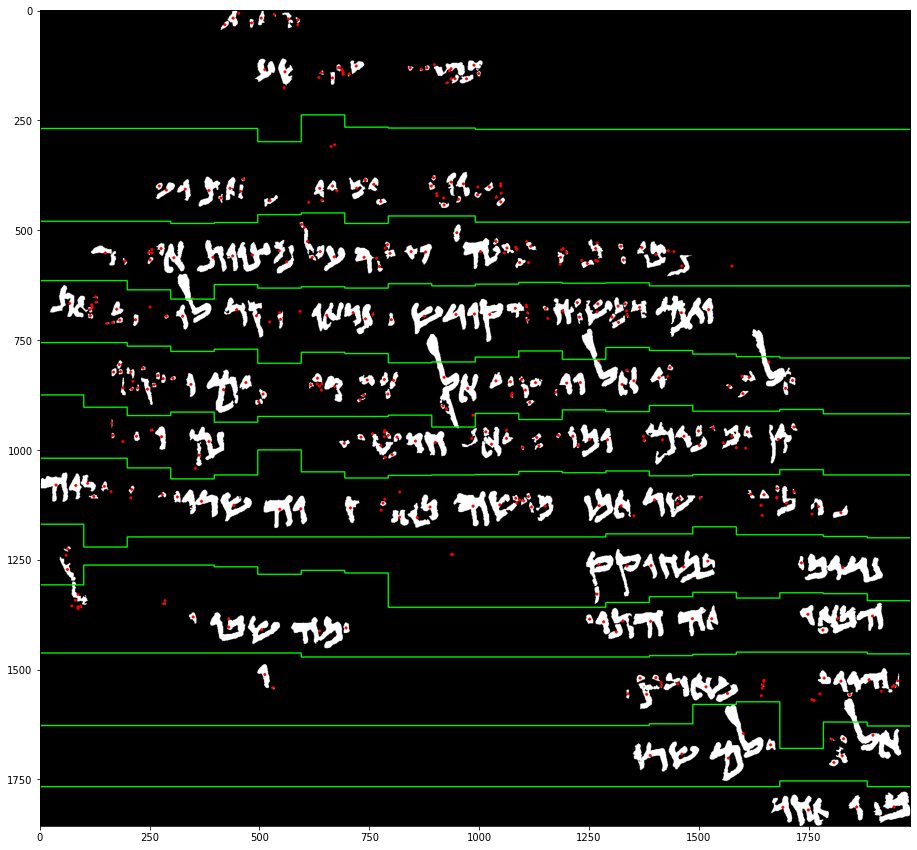

..\data\dss\scrolls\P123-Fg001-R-C01-R01-binarized.jpg


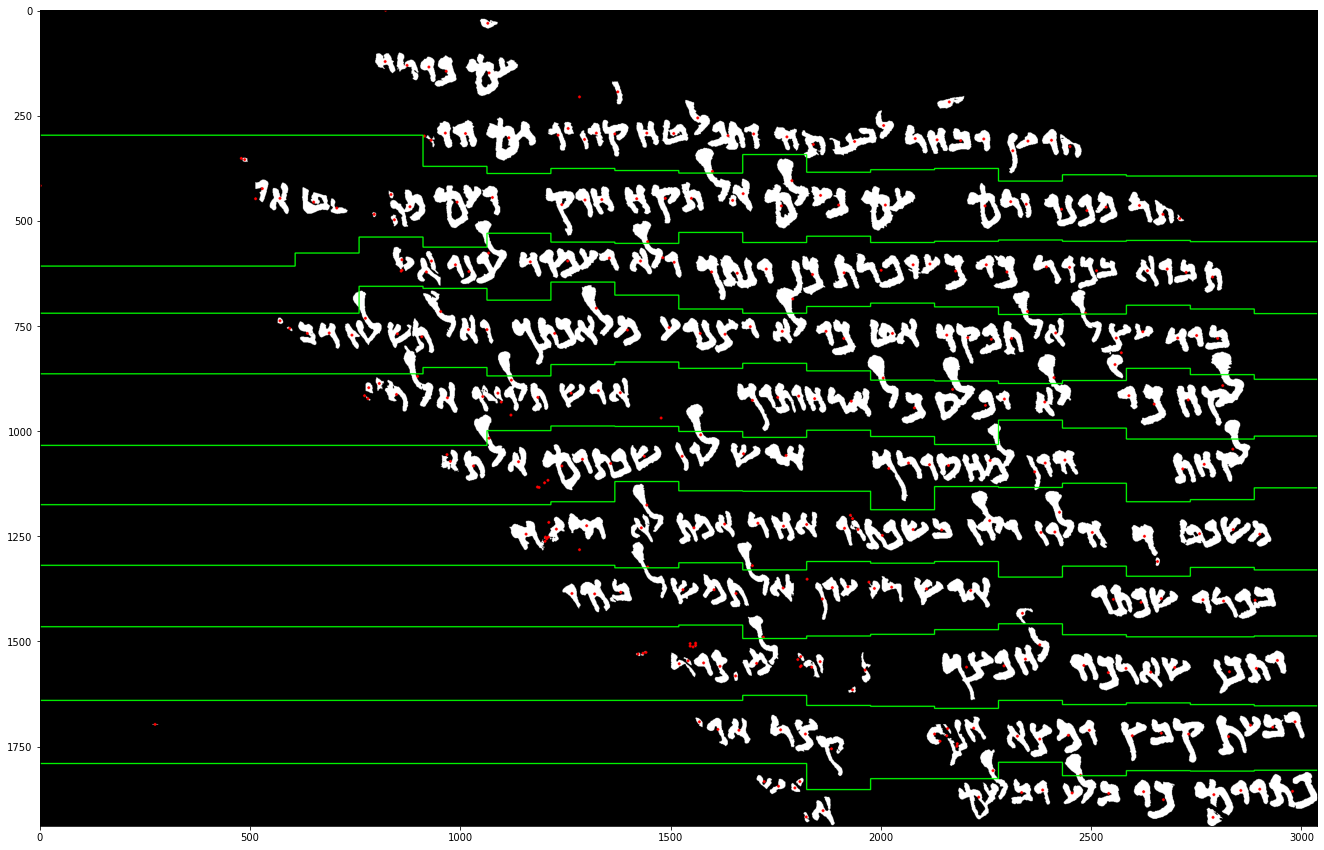

..\data\dss\scrolls\P123-Fg002-R-C01-R01-binarized.jpg


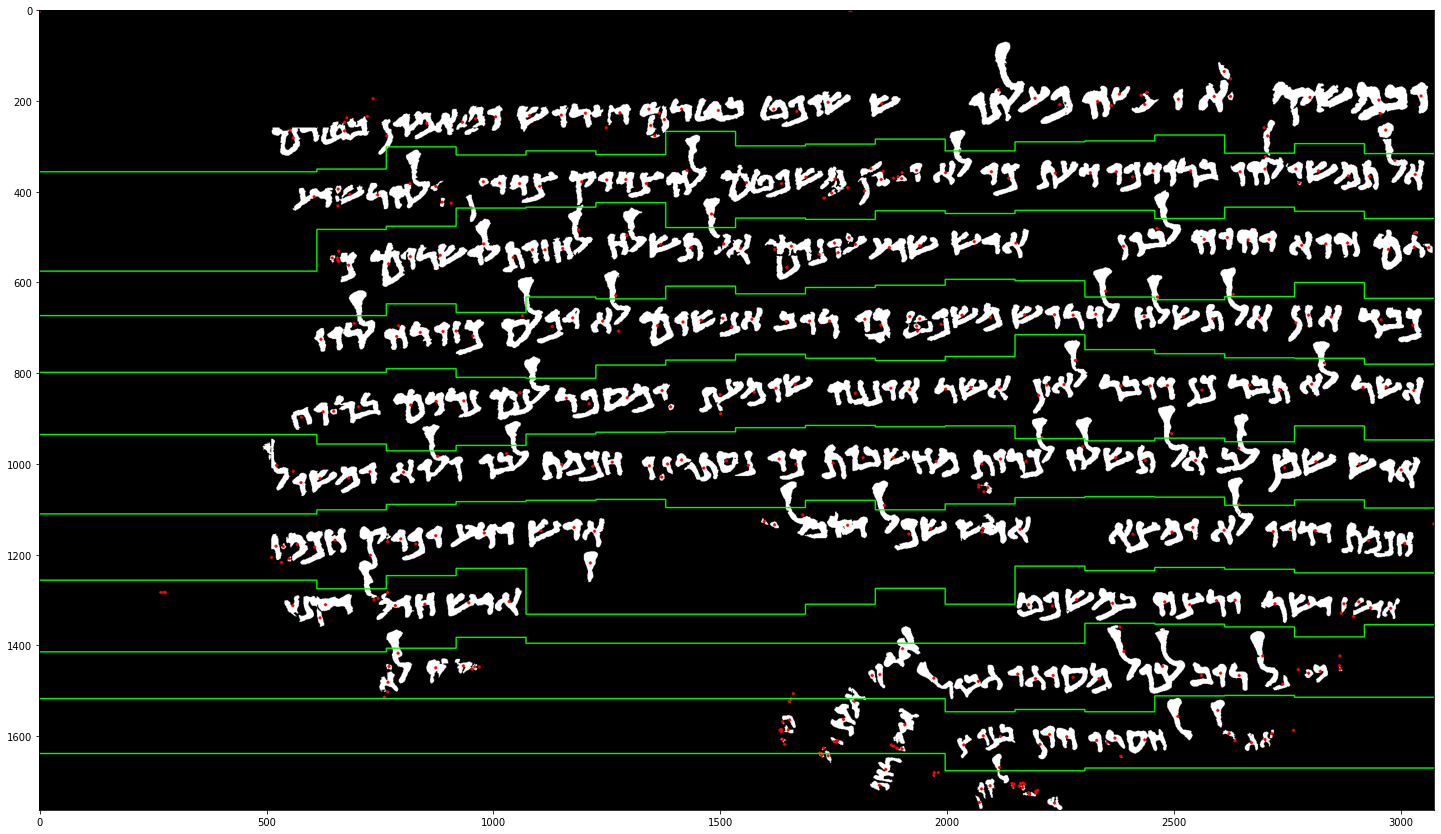

..\data\dss\scrolls\P166-Fg002-R-C01-R01-binarized.jpg


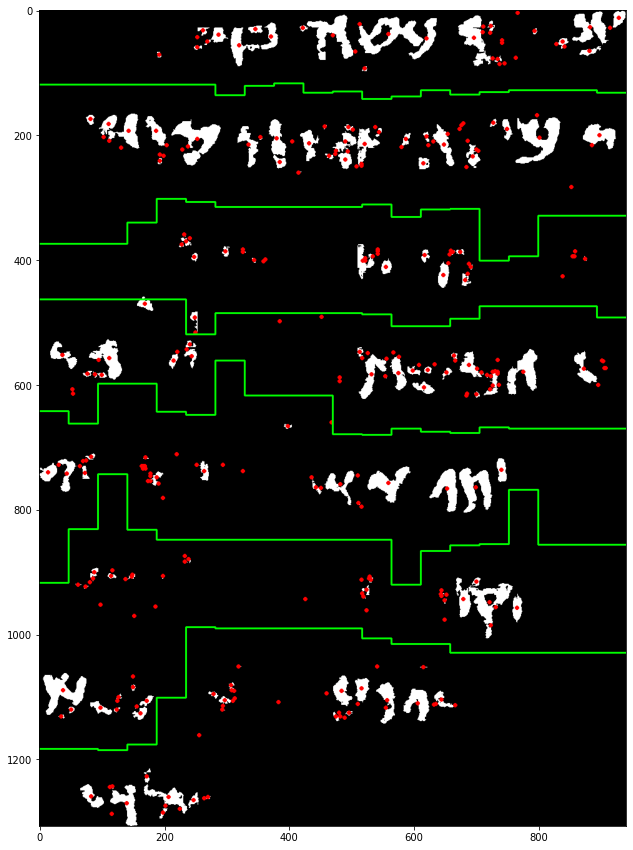

..\data\dss\scrolls\P166-Fg007-R-C01-R01-binarized.jpg


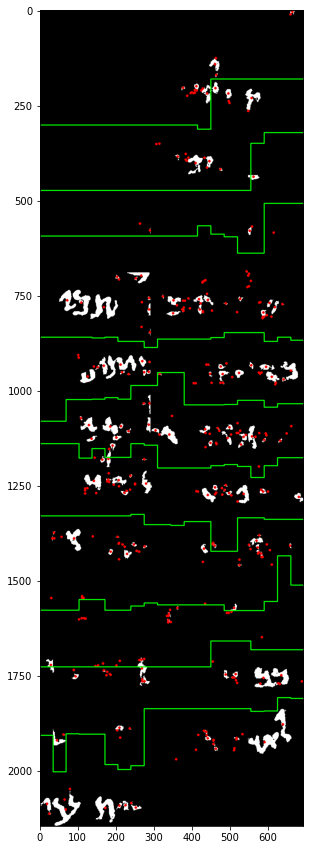

..\data\dss\scrolls\P168-Fg016-R-C01-R01-binarized.jpg


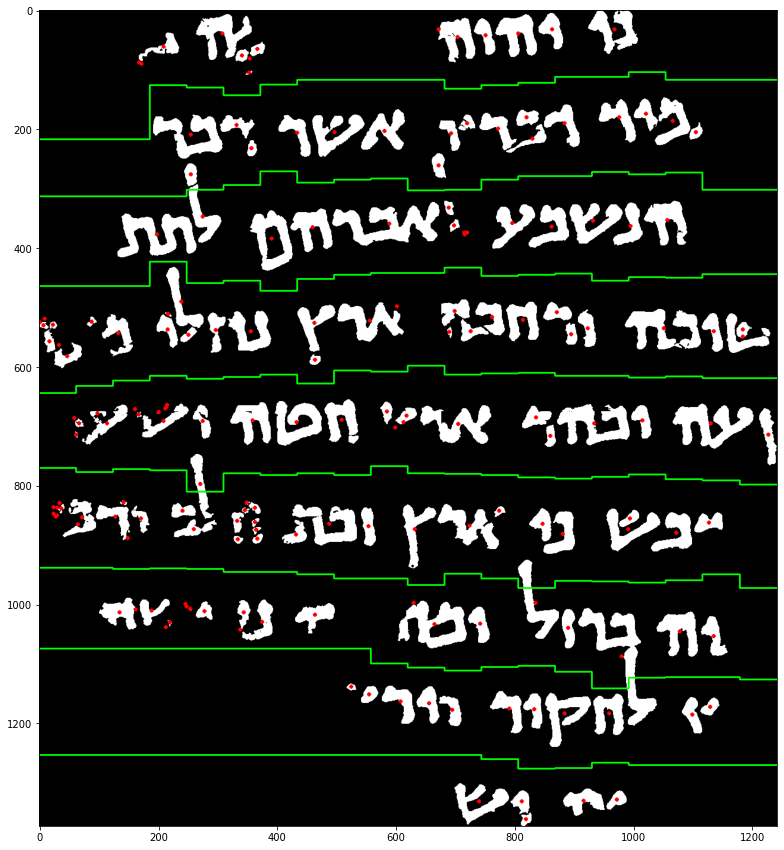

..\data\dss\scrolls\P172-Fg001-R-C01-R01-binarized.jpg


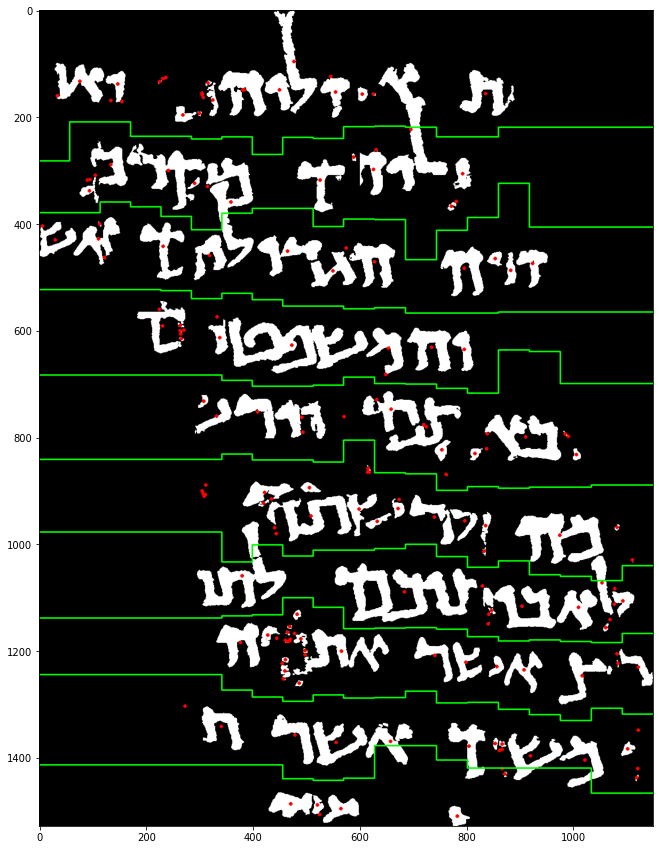

..\data\dss\scrolls\P21-Fg006-R-C01-R01-binarized.jpg


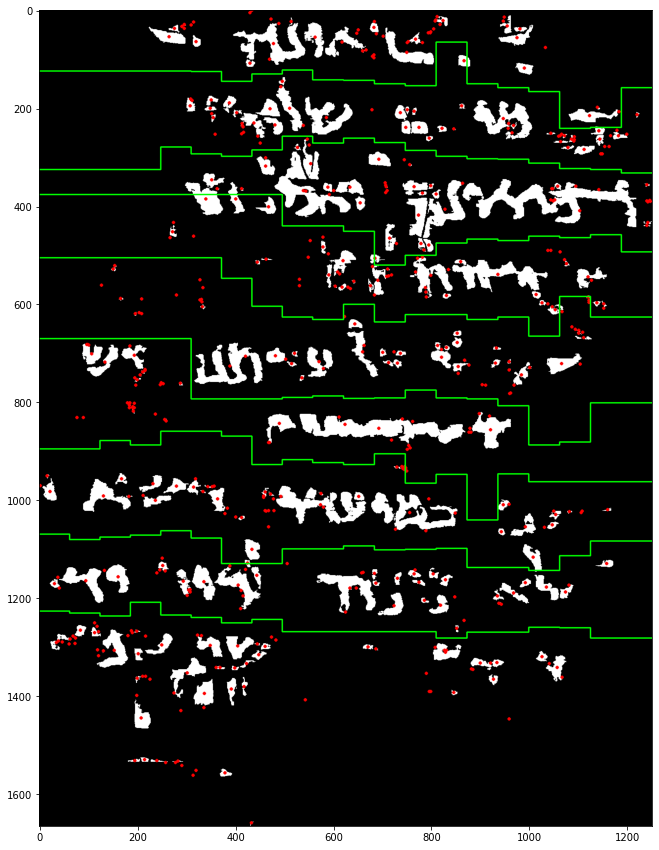

..\data\dss\scrolls\P22-Fg008-R-C01-R01-binarized.jpg


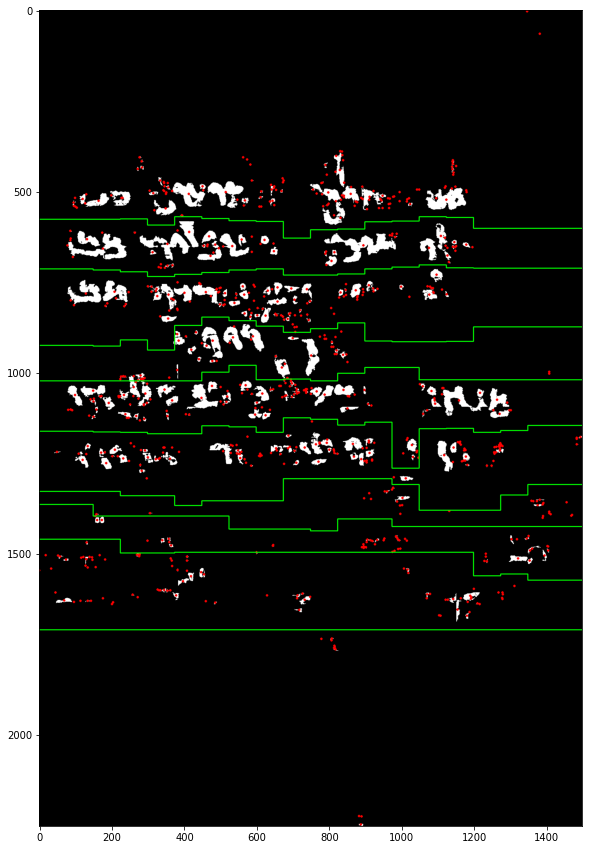

..\data\dss\scrolls\P342-Fg001-R-C01-R01-binarized.jpg


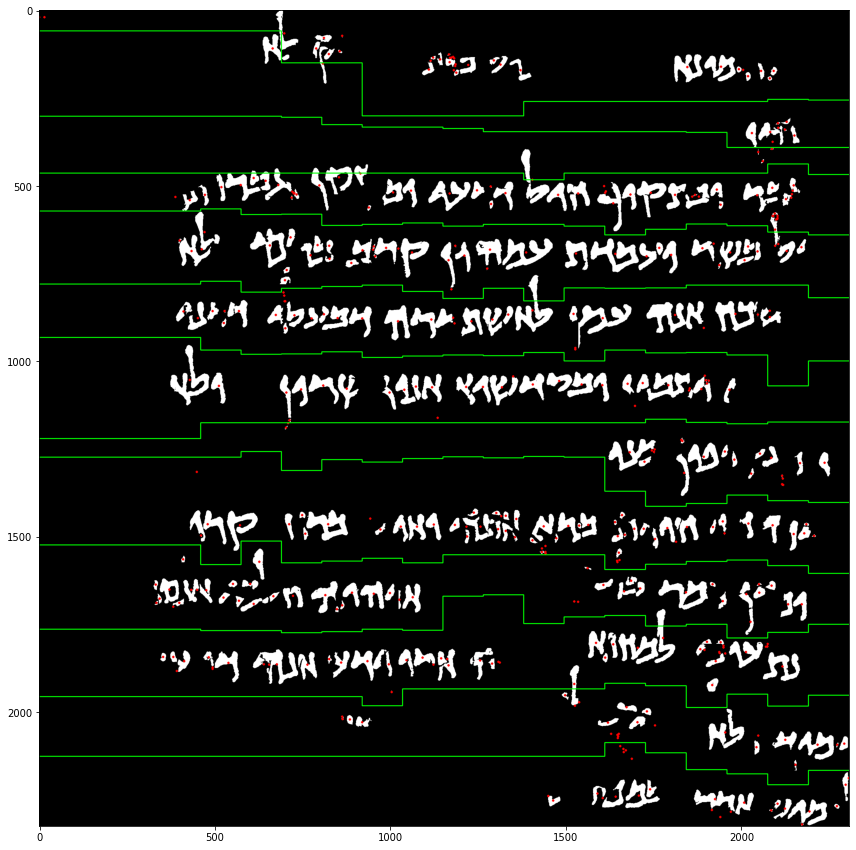

..\data\dss\scrolls\P344-Fg001-R-C01-R01-binarized.jpg


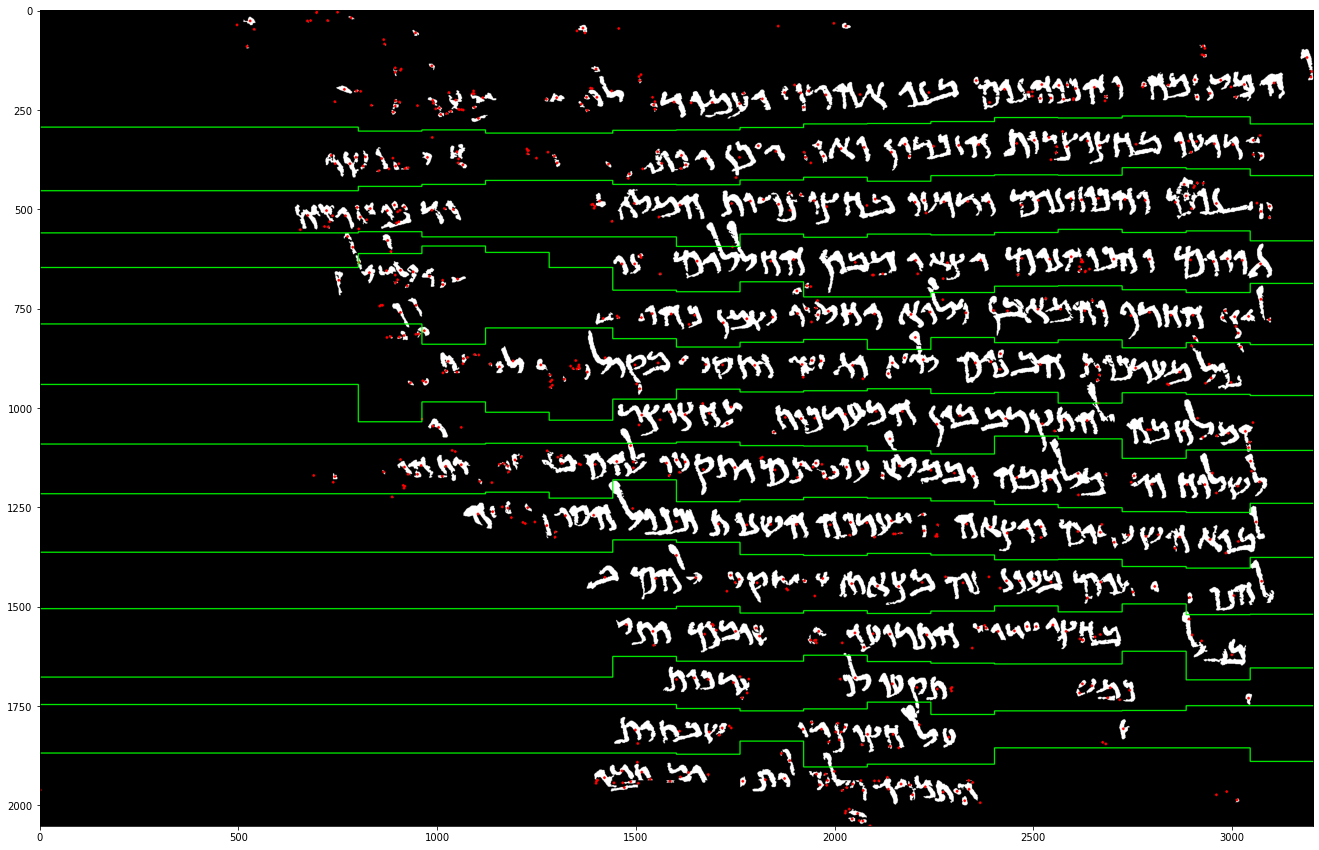

..\data\dss\scrolls\P423-1-Fg002-R-C01-R01-binarized.jpg


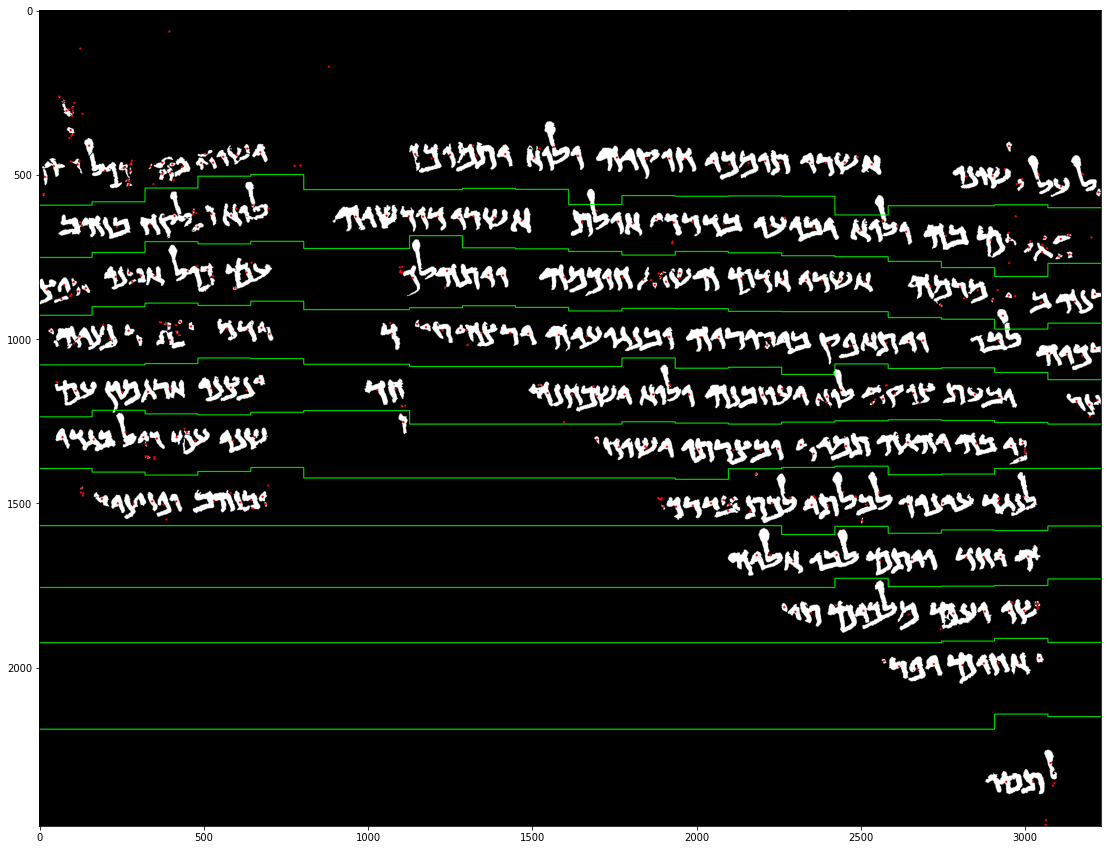

..\data\dss\scrolls\P423-1-Fg002-R-C02-R01-binarized.jpg


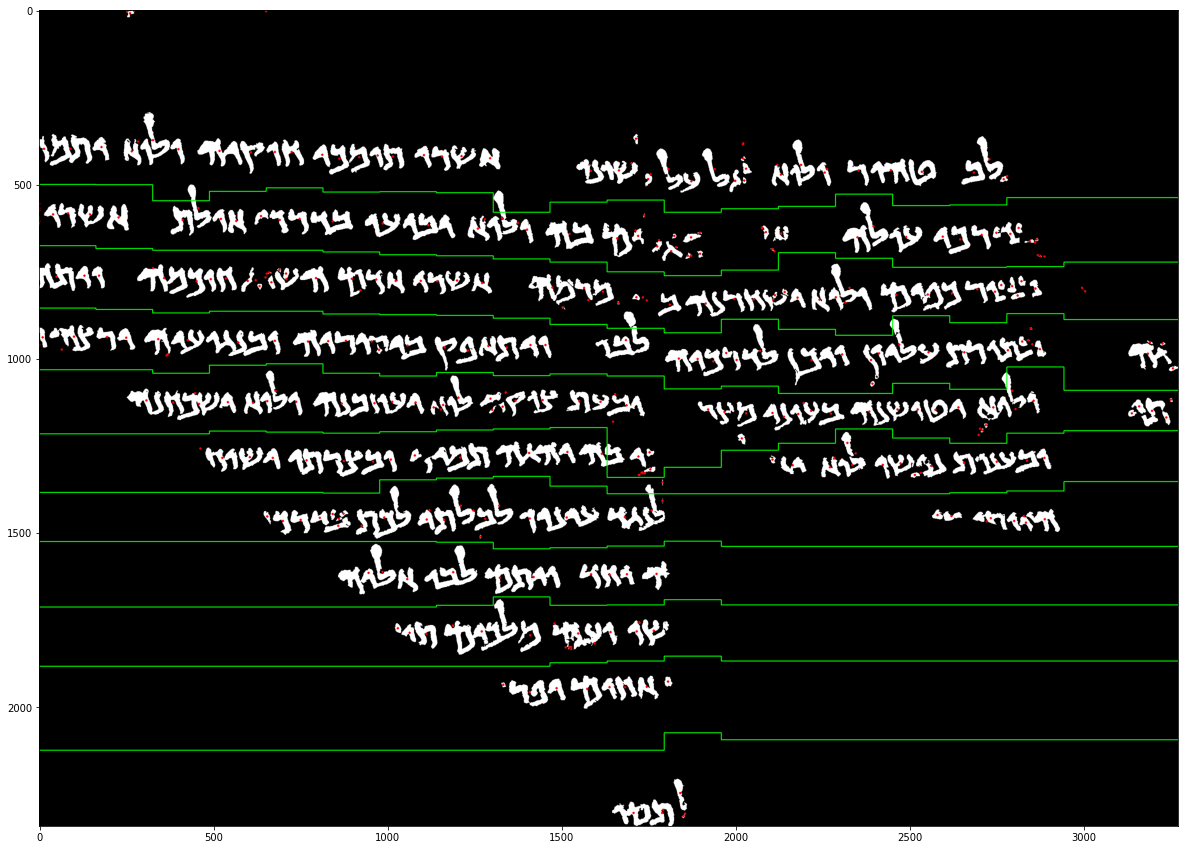

..\data\dss\scrolls\P513-Fg001-R-C01-R01-binarized.jpg


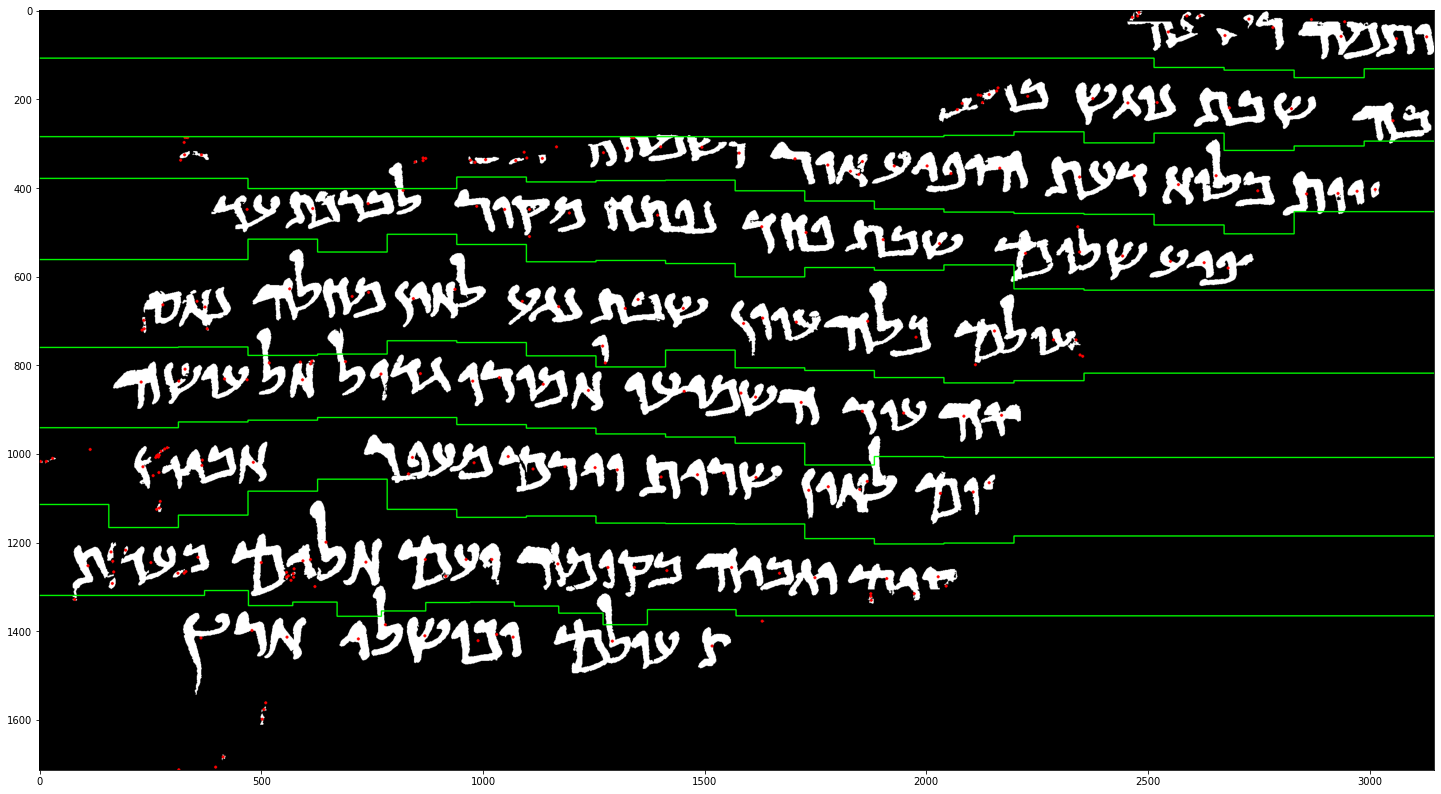

..\data\dss\scrolls\P564-Fg003-R-C01-R01-binarized.jpg


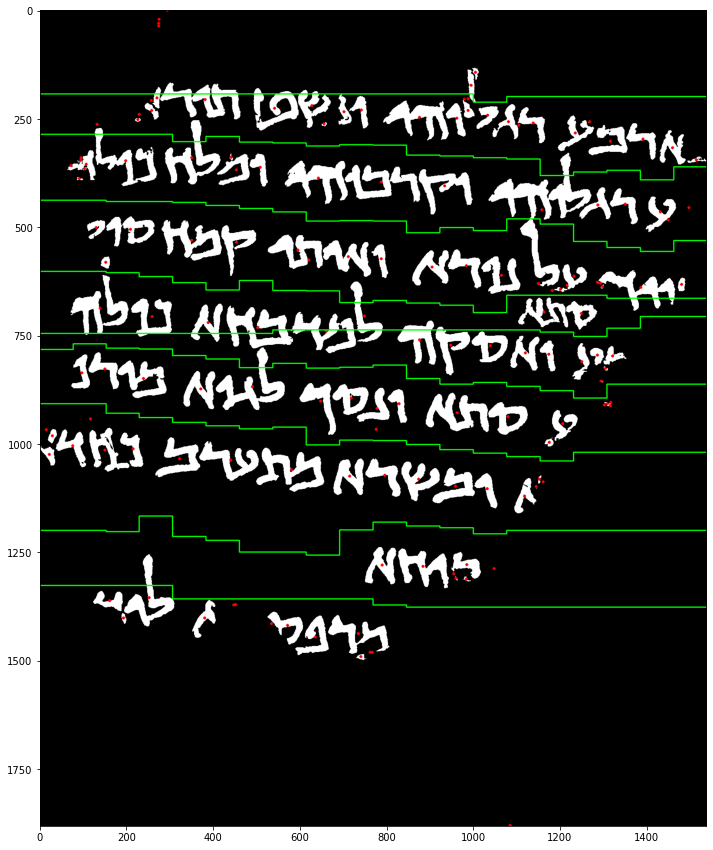

..\data\dss\scrolls\P583-Fg002-R-C01-R01-binarized.jpg


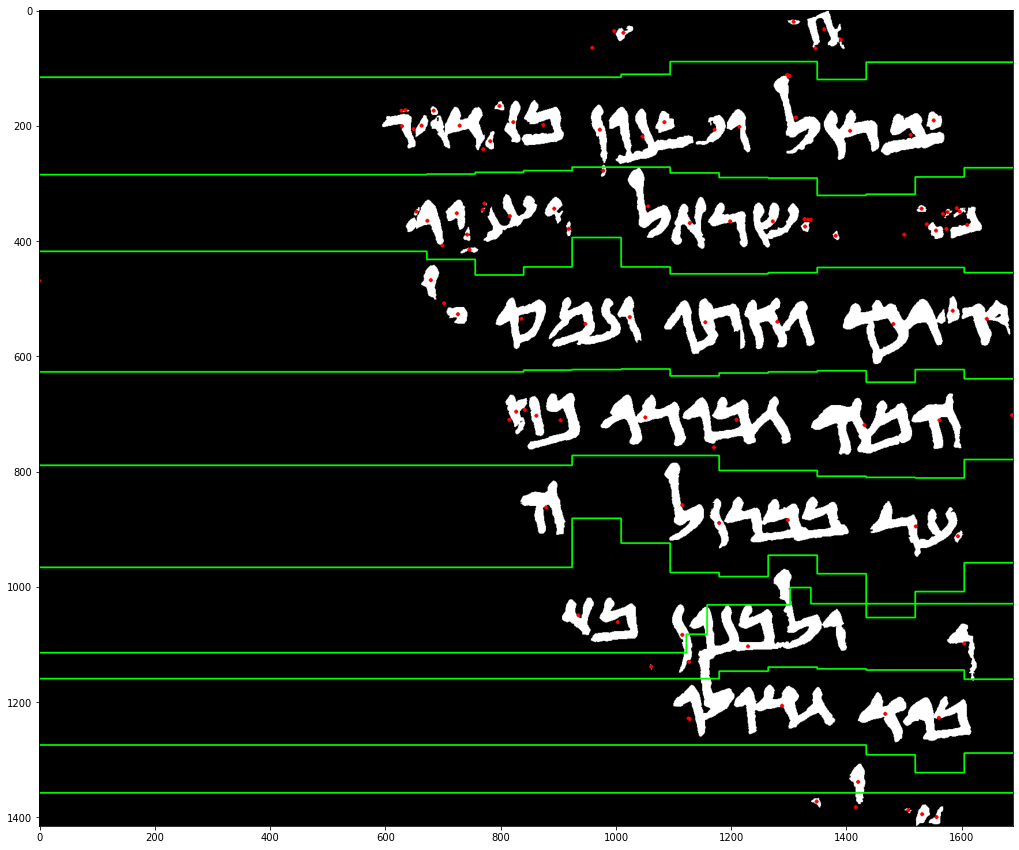

..\data\dss\scrolls\P583-Fg006-R-C01-R01-binarized.jpg


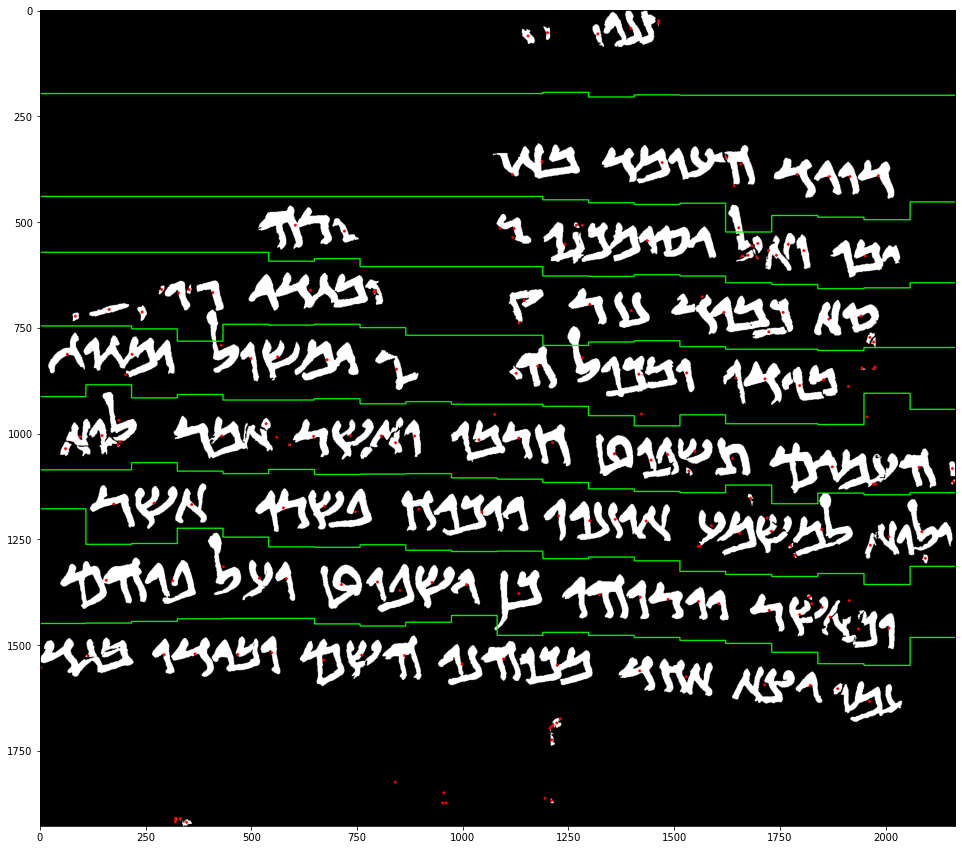

..\data\dss\scrolls\P632-Fg001-R-C01-R01-binarized.jpg


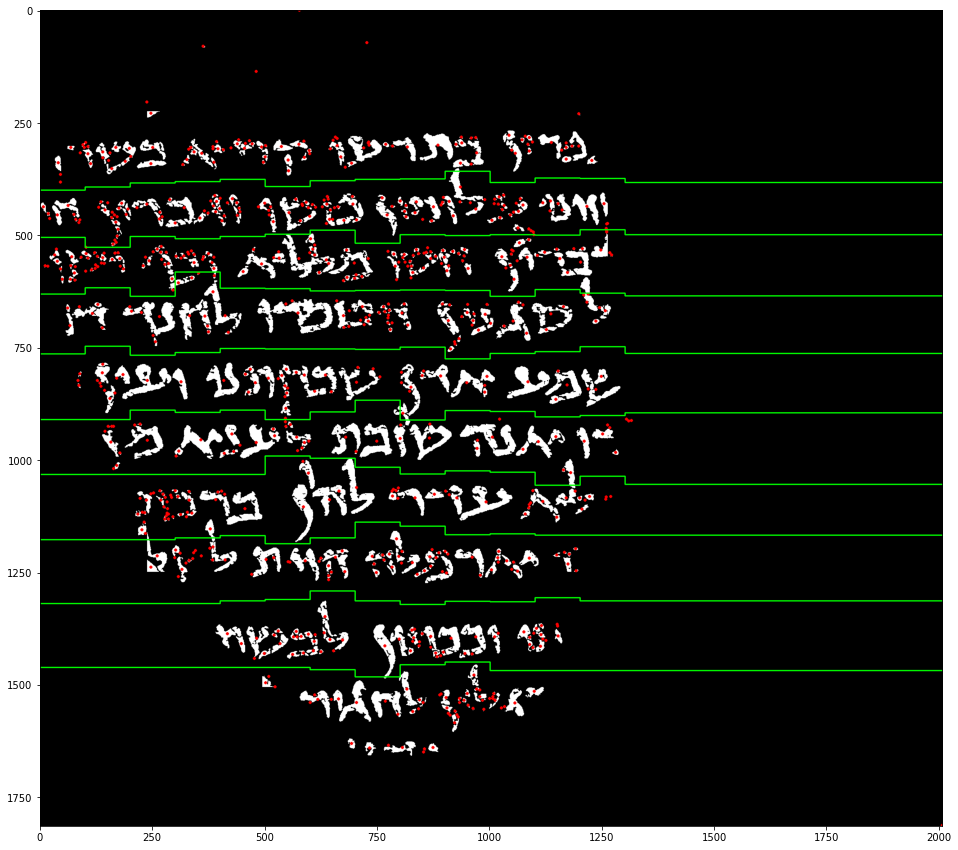

..\data\dss\scrolls\P632-Fg002-R-C01-R01-binarized.jpg


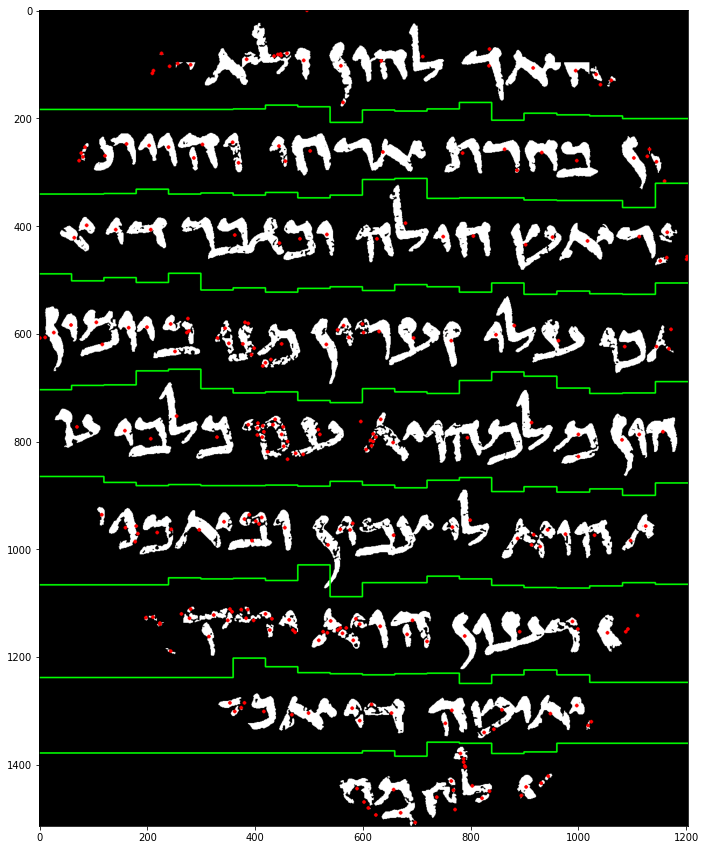

..\data\dss\scrolls\P846-Fg001-R-C01-R01-binarized.jpg


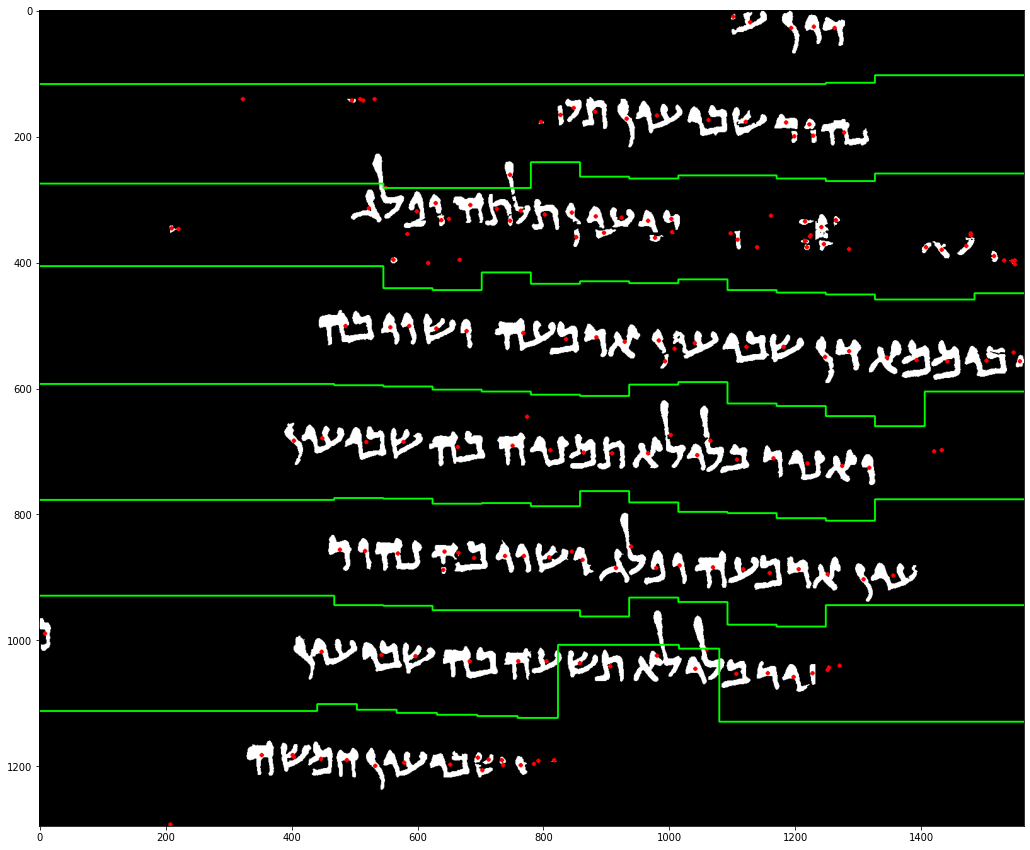

In [99]:
test()

In [97]:
def image_between_lines(im, line1, line2, ccs, offset):
    (ox,oy,ow,oh) = offset
    def line_y_from_x(line, x):
        curr_x = 0
        for (y, w) in line:
            if curr_x < x-ox <= curr_x + w:
                return y+oy
            curr_x += w
        return line[-1][0]
    ccs_line = []
    for cc in ccs:
        fbound = line_y_from_x(line1, cc.cx)
        sbound = line_y_from_x(line2, cc.cx)
        lbound = min(fbound, sbound)
        ubound = max(fbound, sbound)
        if lbound <= cc.cy <= ubound:
            ccs_line.append(cc)
    return get_line_image_from_ccs(im, ccs_line)[0]

import os
def pipeline(in_path, out_path, cc_min_a, cc_max_a, start_lookahead, chunk_lookahead, expected_line_height):
    path = Path(in_path)
    out = Path(out_path)
    os.makedirs(out, exist_ok=True)
    files = path.glob('*binarized.jpg')

    def save(directory, id, oim):
        fn = directory / f'line-{id}.jpg'
        print(f'\t=> {fn}')
        if cv.countNonZero(oim) == 0: return False
        cv.imwrite(str(fn), oim)
        return True

    for file in files:
        print(str(file))
        directory = out / file.name.split('.')[0]
        os.makedirs(directory)
        im = cv.imread(str(file))
        im = preprocessed(im)
        ccs = get_ccs_from_image(im)
        ccs = [cc for cc in ccs if cc_min_a <= cc.a <= cc_max_a]
        lines, offset = traverse(im,
                                 start_lookahead=start_lookahead, chunk_lookahead=chunk_lookahead,
                                 expected_line_height=expected_line_height, log=none)
        lines = [[(0, im.shape[1])]] + lines + [[(im.shape[0], im.shape[1])]]
        line_id = 0
        for i, line in enumerate(lines):
            if i == 0:
                continue
            oim = image_between_lines(im, lines[i-1], line, ccs, offset)
            if save(directory, line_id, oim):
                line_id += 1

pipeline(Path('../data/dss/scrolls'), Path('./out'), 500, 1e5, 50, 40, 200)

..\data\dss\scrolls\P106-Fg002-R-C01-R01-binarized.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-0.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-1.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-2.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-3.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-4.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-5.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-6.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-7.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-8.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-9.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-10.jpg
	=> out\P106-Fg002-R-C01-R01-binarized\line-11.jpg
..\data\dss\scrolls\P123-Fg001-R-C01-R01-binarized.jpg
	=> out\P123-Fg001-R-C01-R01-binarized\line-0.jpg
	=> out\P123-Fg001-R-C01-R01-binarized\line-1.jpg
	=> out\P123-Fg001-R-C01-R01-binarized\line-2.jpg
	=> out\P123-Fg001-R-C01-R01-binarized\line-3.jpg
	=> out\P123-Fg001-R-C01-R01-binarized\line-4.jpg
	=> out\P123-Fg001-R-C01-R01-binarized

In [95]:
p = Path('../data/dss/scrolls')
files = p.glob('*binarized.jpg')
for file in files:
    print(file.name)
    break

P106-Fg002-R-C01-R01-binarized.jpg


In [ ]:
def test(axis=1):
    im = cv.imread(IMG_PATH)
    im = preprocessed(im)
    ccs = get_ccs_from_image(im)
    extreme_ccs = [cc for cc in ccs if cc.a < 500]
    for cc in extreme_ccs:
        im[cc.y:cc.y+cc.h, cc.x:cc.x+cc.w] = np.zeros((cc.h, cc.w))
    im, d = crop(im)
    pimg(im)
    tiles = to_grid(im, 2, 2)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    i=0
    for (pos, tile) in tiles:
        if cv.countNonZero(tile) < 5:
            continue
        reductions = reduce_optimally(tile, axis=axis)
        tile, tile_dim = crop(tile)
        tile = cv.cvtColor(tile, cv.COLOR_GRAY2RGB)
        if reductions:
            i+=1
            path = f'/home/jsk/Study/2-4-hwr/Handwriting_Recognition/jesper_tests/out/{i}.jpg'
            rotim = rot_from_red(tile, *reductions, axis=axis)
            # print(f"writing to {path}")
            cv.imwrite(path, rotim)
            eqs = equations_from_reductions(tile, *reductions, axis=axis)
            for x,y in eqs:
                x_offset = pos.x + tile_dim[0]
                y_offset = pos.y + tile_dim[1]
                cv.line(tile, (y(0), x(0)), (y(tile.shape[1]), x(tile.shape[1])), (0, 255, 0), 1)
                cv.line(im, (y(0)+x_offset, x(0)+y_offset), (y(tile.shape[1])+x_offset, x(tile.shape[1])+y_offset), (0, 255, 0), 1)
            # print(r)
            fig, (a1, a2) = plt.subplots(1, 2)
            a1.imshow(rotim, cmap='binary')
            a2.imshow(tile, cmap='binary')
            plt.show()
            # pimg(tile)
    pimg(im)

test()

In [ ]:
def projection_profile(chunk, window_length=5):
    reduced = cv.reduce(chunk // 255, 1, cv.REDUCE_SUM, dtype=cv.CV_32S).flatten()
    kernel = np.ones(window_length) / window_length
    return np.convolve(reduced, kernel, mode='same')


def valleys_from_profile(profile, *args, **kwargs):
    peaks, _ = peakdetect(profile, *args, **kwargs)
    if len(peaks) == 0:
        return []
    peak_locs, _ = zip(*peaks)
    # plt.plot(prof)
    # for (x,y) in peaks:
    #     plt.axvline(x)
    # plt.show()
    # start = cv.cvtColor(start, cv.COLOR_GRAY2RGB)
    valley_locs = []
    for i, y in enumerate(peak_locs):
        if i==0:
            continue
        y_lag = peak_locs[i-1]
        valley_locs.append(np.argmin(profile[y_lag:y]) + y_lag)
        # valley = np.argmin(profile[y_lag:y]) + y_lag
        # cv.line(start, (0, valley), (start.shape[1], valley), (0, 255, 0))
    # plt.show()
    # plt.imshow(start)
    return valley_locs


def annotate_image_with_lines(im, chunks, lines):
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    for line in lines:
        x = im.shape[1]
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            cv.line(im, (x,y), (x-w,y), (0, 255, 0), 2)
            if i < len(line)-1:
                prev_y = line[i-1]
                cv.line(im, (x,y), (x,prev_y), (0, 255, 0), 2)
            x -= w
    return im


def none(*args, **kwargs):
    pass


def traverse(im, n_splits=20, line_start_splits=10, start_lookahead=70, chunk_lookahead=70, second_pass=False, log=none):
    im, dims = crop(im)
    if cv.countNonZero(im) == 0:
        print('Empty image!')
        return []
    chunks = to_chunks(im, n_splits)

    # Line starts
    start = np.column_stack(tuple(chunks[-line_start_splits:]))
    prof = projection_profile(start)
    line_starts = valleys_from_profile(prof, lookahead=start_lookahead)
    if len(line_starts) == 0:
        print('Could not find any peaks!')
        return []

    lines = [[y] for y in line_starts]
    valleys_per_chunk = [valleys_from_profile(projection_profile(chunk), lookahead=chunk_lookahead) \
                               for chunk in chunks]

    # Line traversal
    for i in range(2, n_splits+1):
        log(f'\nChunk {i}')
        curr_valleys = valleys_per_chunk[-i]
        log(f'Valleys at {curr_valleys}')
        line_ending_to_closest_valley = {}
        line_endings = [line[-1] for line in lines]
        log(f'Line endings at {line_endings}')
        for valley in curr_valleys:
            log(f'Valley {valley}')
            distances = np.array([abs(valley - line_ending) for line_ending in line_endings])
            log(f'\tDistances: {distances}')
            closest_line_ending_idx = np.argmin(distances)
            closest_line_ending = line_endings[closest_line_ending_idx]
            distance_to_closest_line_ending = distances[closest_line_ending_idx]
            log(f'\tClosest at {closest_line_ending_idx}: {closest_line_ending} w/ distance {distance_to_closest_line_ending}')
            if distance_to_closest_line_ending > 60:
                log('\tToo far away!')
                continue
            if closest_line_ending in line_ending_to_closest_valley:
                other, other_distance = line_ending_to_closest_valley[closest_line_ending]
                log(f'\tAlready used by {other} w/ dist {other_distance}')
                if distance_to_closest_line_ending < other_distance:
                    log(f'\tIm closer! Throwing them out...')
                    line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
                else:
                    # TODO: inline annotations oppikken
                    log(f'\tThey are closer, carefully dying...')
            else:
                log(f'\tFirst! Assigning...')
                line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
        log(line_ending_to_closest_valley)

        for line in lines:
            line_ending = line[-1]
            log(f'looking for line from line ending {line_ending}')
            next_y = line_ending_to_closest_valley[line_ending][0] if line_ending in line_ending_to_closest_valley else line_ending
            log(f'next: {next_y}')
            line.append(next_y)
    # End for chunk in chunks

    # Get heights of every line
    line_heights = []
    for i, line_start in enumerate(line_starts):
        if i==0:
            line_heights.append(line_start)
        else:
            line_heights.append(line_start - line_starts[i-1])
    line_heights.append(im.shape[0] - line_starts[-1])
    line_heights = np.array(line_heights)

    mean = line_heights.mean()
    std = line_heights.std()
    print(line_heights)
    for i, line_height in enumerate(line_heights):
        if line_height - mean > std:
            print(f"Second pass for line {i}")
            y_from = line_starts[i]
            y_to = line_starts[i+1] if i < len(line_starts) else im.shape[0]
            nested_lines, (nx, ny, nw, nh) = traverse(im[y_from:y_to, ...], n_splits, line_start_splits, start_lookahead, chunk_lookahead, second_pass=True, log=log)
            nested_lines = []
            for j, nested_line in enumerate(nested_lines):
                lines.insert(i+j, nested_line)
            # do something

    lines_full = []
    for line in lines:
        line_full = []
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            line_full += [(y, w)]
        lines_full.append(line_full)

    return lines_full, dims
    #
    # im = annotate_image_with_lines(im, chunks, lines)
    # pimg(im)


from pathlib import Path

def test():
    p = Path('../data/dss/scrolls')
    files = p.glob('*binarized.jpg')
    for file in files:
        print(file)
        im = cv.imread(str(file))
        im = preprocessed(im)
        traverse(im)

test()

In [142]:
def test(axis=1):
    im = cv.imread(IMG_PATH)
    im = preprocessed(im)
    ccs = get_ccs_from_image(im)
    extreme_ccs = [cc for cc in ccs if cc.a < 500]
    for cc in extreme_ccs:
        im[cc.y:cc.y+cc.h, cc.x:cc.x+cc.w] = np.zeros((cc.h, cc.w))
    im, d = crop(im)
    pimg(im)
    tiles = to_grid(im, 2, 2)
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    i=0
    for (pos, tile) in tiles:
        if cv.countNonZero(tile) < 5:
            continue
        reductions = reduce_optimally(tile, axis=axis)
        tile, tile_dim = crop(tile)
        tile = cv.cvtColor(tile, cv.COLOR_GRAY2RGB)
        if reductions:
            i+=1
            path = f'/home/jsk/Study/2-4-hwr/Handwriting_Recognition/jesper_tests/out/{i}.jpg'
            rotim = rot_from_red(tile, *reductions, axis=axis)
            # print(f"writing to {path}")
            cv.imwrite(path, rotim)
            eqs = equations_from_reductions(tile, *reductions, axis=axis)
            for x,y in eqs:
                x_offset = pos.x + tile_dim[0]
                y_offset = pos.y + tile_dim[1]
                cv.line(tile, (y(0), x(0)), (y(tile.shape[1]), x(tile.shape[1])), (0, 255, 0), 1)
                cv.line(im, (y(0)+x_offset, x(0)+y_offset), (y(tile.shape[1])+x_offset, x(tile.shape[1])+y_offset), (0, 255, 0), 1)
            # print(r)
            fig, (a1, a2) = plt.subplots(1, 2)
            a1.imshow(rotim, cmap='binary')
            a2.imshow(tile, cmap='binary')
            plt.show()
            # pimg(tile)
    pimg(im)

#test()

In [143]:
def projection_profile(chunk, window_length=5):
    reduced = cv.reduce(chunk // 255, 1, cv.REDUCE_SUM, dtype=cv.CV_32S).flatten()
    kernel = np.ones(window_length) / window_length
    return np.convolve(reduced, kernel, mode='same')


def valleys_from_profile(profile, *args, **kwargs):
    peaks, _ = peakdetect(profile, *args, **kwargs)
    if len(peaks) == 0:
        return []
    peak_locs, _ = zip(*peaks)
    # plt.plot(prof)
    # for (x,y) in peaks:
    #     plt.axvline(x)
    # plt.show()
    # start = cv.cvtColor(start, cv.COLOR_GRAY2RGB)
    valley_locs = []
    for i, y in enumerate(peak_locs):
        if i==0:
            continue
        y_lag = peak_locs[i-1]
        valley_locs.append(np.argmin(profile[y_lag:y]) + y_lag)
        # valley = np.argmin(profile[y_lag:y]) + y_lag
        # cv.line(start, (0, valley), (start.shape[1], valley), (0, 255, 0))
    # plt.show()
    # plt.imshow(start)
    return valley_locs


def annotate_image_with_lines(im, chunks, lines):
    im = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    for line in lines:
        x = im.shape[1]
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            cv.line(im, (x,y), (x-w,y), (0, 255, 0), 2)
            if i < len(line)-1:
                prev_y = line[i-1]
                cv.line(im, (x,y), (x,prev_y), (0, 255, 0), 2)
            x -= w
    return im


def none(*args, **kwargs):
    pass


def traverse(im, n_splits=20, line_start_splits=10, start_lookahead=70, chunk_lookahead=70, second_pass=False, log=none):
    im, dims = crop(im)
    if cv.countNonZero(im) == 0:
        print('Empty image!')
        return []
    chunks = to_chunks(im, n_splits)

    # Line starts
    start = np.column_stack(tuple(chunks[-line_start_splits:]))
    prof = projection_profile(start)
    line_starts = valleys_from_profile(prof, lookahead=start_lookahead)
    if len(line_starts) == 0:
        print('Could not find any peaks!')
        return []

    lines = [[y] for y in line_starts]
    valleys_per_chunk = [valleys_from_profile(projection_profile(chunk), lookahead=chunk_lookahead) \
                               for chunk in chunks]

    # Line traversal
    for i in range(2, n_splits+1):
        log(f'\nChunk {i}')
        curr_valleys = valleys_per_chunk[-i]
        log(f'Valleys at {curr_valleys}')
        line_ending_to_closest_valley = {}
        line_endings = [line[-1] for line in lines]
        log(f'Line endings at {line_endings}')
        for valley in curr_valleys:
            log(f'Valley {valley}')
            distances = np.array([abs(valley - line_ending) for line_ending in line_endings])
            log(f'\tDistances: {distances}')
            closest_line_ending_idx = np.argmin(distances)
            closest_line_ending = line_endings[closest_line_ending_idx]
            distance_to_closest_line_ending = distances[closest_line_ending_idx]
            log(f'\tClosest at {closest_line_ending_idx}: {closest_line_ending} w/ distance {distance_to_closest_line_ending}')
            if distance_to_closest_line_ending > 60:
                log('\tToo far away!')
                continue
            if closest_line_ending in line_ending_to_closest_valley:
                other, other_distance = line_ending_to_closest_valley[closest_line_ending]
                log(f'\tAlready used by {other} w/ dist {other_distance}')
                if distance_to_closest_line_ending < other_distance:
                    log(f'\tIm closer! Throwing them out...')
                    line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
                else:
                    # TODO: inline annotations oppikken
                    log(f'\tThey are closer, carefully dying...')
            else:
                log(f'\tFirst! Assigning...')
                line_ending_to_closest_valley[closest_line_ending] = (valley, distance_to_closest_line_ending)
        log(line_ending_to_closest_valley)

        for line in lines:
            line_ending = line[-1]
            log(f'looking for line from line ending {line_ending}')
            next_y = line_ending_to_closest_valley[line_ending][0] if line_ending in line_ending_to_closest_valley else line_ending
            log(f'next: {next_y}')
            line.append(next_y)
    # End for chunk in chunks

    # Get heights of every line
    line_heights = []
    for i, line_start in enumerate(line_starts):
        if i==0:
            line_heights.append(line_start)
        else:
            line_heights.append(line_start - line_starts[i-1])
    line_heights.append(im.shape[0] - line_starts[-1])
    line_heights = np.array(line_heights)

    mean = line_heights.mean()
    std = line_heights.std()
    print(line_heights)
    for i, line_height in enumerate(line_heights):
        if line_height - mean > std:
            print(f"Second pass for line {i}")
            y_from = line_starts[i]
            y_to = line_starts[i+1] if i < len(line_starts) else im.shape[0]
            nested_lines, (nx, ny, nw, nh) = traverse(im[y_from:y_to, ...], n_splits, line_start_splits, start_lookahead, chunk_lookahead, second_pass=True, log=log)
            nested_lines = []
            for j, nested_line in enumerate(nested_lines):
                lines.insert(i+j, nested_line)
            # do something

    lines_full = []
    for line in lines:
        line_full = []
        for i,y in enumerate(line):
            curr_chunk = chunks[-(i+1)]
            w = curr_chunk.shape[1]
            line_full += [(y, w)]
        lines_full.append(line_full)

    return lines_full, dims
    #
    # im = annotate_image_with_lines(im, chunks, lines)
    # pimg(im)


from pathlib import Path

def test():
    p = Path('../data/dss/scrolls')
    files = p.glob('*binarized.jpg')
    for file in files:
        print(file)
        im = cv.imread(str(file))
        im = preprocessed(im)
        traverse(im)

#test()